In [98]:
%matplotlib inline
from config_calc import *

import xarray as xr
import numpy as np

import cesm_orcas_sci as cesm
import xcalendar as xcal

import dask
import dask.distributed
import ncar_jobqueue

import matplotlib.pyplot as plt
import cartopy
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import cmocean

In [2]:
cluster = ncar_jobqueue.NCARCluster(cores=18,
                                    processes=18)
client = dask.distributed.Client(cluster)
n_workers = 18 * 2
cluster.scale(n_workers)

/glade/work/mclong/miniconda3/envs/analysis/lib/python3.7/site-packages/distributed/deploy/local.py:106: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "


In [3]:
!qstat | grep dask-worker

/usr/bin/sh: module: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_module'
/usr/bin/sh: ml: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_ml'
5167173.chadmin1  dask-worker      mclong                   0 Q regular         


In [4]:
client

Client Scheduler: tcp://10.148.8.164:41528 Dashboard: http://10.148.8.164/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [26]:
case = 'bgeos5.B20TRC5CN.f09_g16.BPRD_orcas_sci.004'
tracer_def = cesm.trace_gas_tracers(case)
tracer_3d = ['CO2', 'CO2_OCN', 'CO2_LND', 'CO2_FFF']

ds = cesm.open_casedata(case,'atm','cam.h0',tracer_3d+['SF'+v for v in tracer_3d if 'IDL' not in v])

ds = cesm.convert_dataset(ds,case)
ds.CO2_OCN.attrs['long_name'] = 'CESM'
ds

<xarray.Dataset>
Dimensions:    (ilev: 57, lat: 192, lev: 56, lon: 288, nbnd: 2, slat: 191, slon: 288, time: 3347)
Coordinates:
  * ilev       (ilev) float64 1.651 2.085 2.62 3.276 ... 955.0 970.0 985.0 1e+03
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lev        (lev) float64 1.868 2.353 2.948 3.677 ... 947.5 962.5 977.5 992.5
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * slat       (slat) float64 -89.53 -88.59 -87.64 -86.7 ... 87.64 88.59 89.53
  * slon       (slon) float64 -0.625 0.625 1.875 3.125 ... 355.6 356.9 358.1
  * time       (time) object 2006-12-31 12:00:00 ... 2016-02-28 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    CO2        (time, lev, lat, lon) float32 dask.array<shape=(3347, 56, 192, 288), chunksize=(5, 56, 192, 288)>
    P0         float64 1e+05
    ch4vmr     (time) float64 dask.array<shape=(3347,), chunksize=(5,)>
    co2vmr     (time) float64 dask.array<shape=(3347,), ch

In [ ]:
for v in ['CO2', 'CO2_LND', 'CO2_OCN', 'CO2_FFF']:
    mn = ds[v].min().values
    mx = ds[v].max().values
    print(f'{v}: {mn}, {mx}')


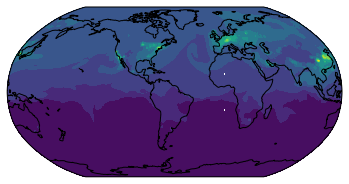

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()

cf = ax.contourf(ds.lon, ds.lat, ds.CO2_FFF.isel(time=-1, lev=-1),
                 transform=ccrs.PlateCarree(), 
                 levels=np.arange(45, 80, 2.5))
ax.coastlines()



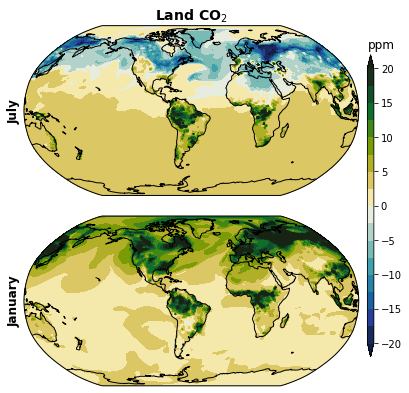

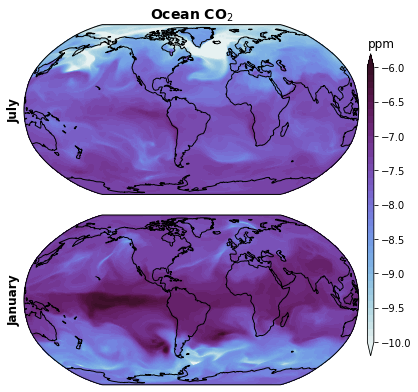

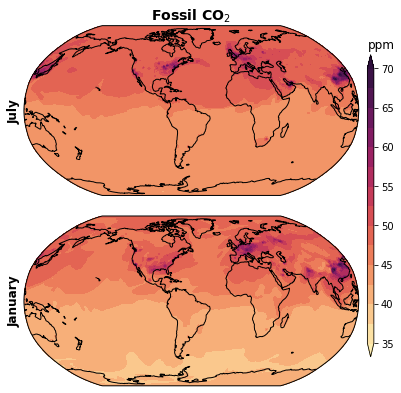

In [101]:
levels = {}
dx = 2.5
levels['CO2_LND']=np.arange(-20, 20+dx, dx)

dx = 0.1
levels['CO2_OCN']=np.arange(-10, -6+dx, dx)

dx = 2.5
levels['CO2_FFF']=np.arange(35, 70+dx, dx)


titles = {'CO2_LND': 'Land CO$_2$', 'CO2_OCN': 'Ocean CO$_2$', 'CO2_FFF': 'Fossil CO$_2$'}


cmap = {'CO2_LND': cmocean.cm.delta, 
        'CO2_OCN': cmocean.cm.dense, 
        'CO2_FFF': cmocean.cm.matter}

date_top = '2015-07-01'
date_bot = '2015-01-01'



def plot(v):
    # figure
    fig = plt.figure(figsize=(6, 7))

    # top axis
    ax = fig.add_subplot(211, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_global()
    ax.set_title(titles[v], fontsize=14, weight='bold')
    plt.text(-0.05, 0.5, 'July', {'color': 'k', 'fontsize': 12, 'weight': 'bold'},
         horizontalalignment='left',
         verticalalignment='center',
         rotation=90,
         clip_on=False,
         transform=plt.gca().transAxes)
    
    axs = []
    field = ds[v].sel(time=date_top).isel(time=0, lev=-1)
    field, lon = add_cyclic_point(field, coord=ds.lon)
    cf = ax.contourf(lon, ds.lat, field,
                     transform=ccrs.PlateCarree(), 
                     cmap=cmap[v],
                     levels=levels[v], 
                     extend='both')
    ax.coastlines()
    axs.append(ax)

    # bottom axis
    ax = fig.add_subplot(212, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_global()
    plt.text(-0.05, 0.5, 'January', {'color': 'k', 'fontsize': 12, 'weight': 'bold'},
         horizontalalignment='left',
         verticalalignment='center',
         rotation=90,
         clip_on=False,
         transform=plt.gca().transAxes)
    
    field = ds[v].sel(time=date_bot).isel(time=0, lev=-1)
    field, lon = add_cyclic_point(field, coord=ds.lon)
    cf = ax.contourf(lon, ds.lat, field,
                     transform=ccrs.PlateCarree(), 
                     cmap=cmap[v],
                     levels=levels[v], 
                     extend='both')
    ax.coastlines()
    axs.append(ax)


    # colorbar
    plt.subplots_adjust(right=0.9,hspace=0.001)
    ptop = axs[0].get_position()
    pbot = axs[-1].get_position()
    height = ptop.y0 + ptop.height - pbot.y0
    cbar_height = 0.6
    y0 = pbot.y0 +height / 2 -cbar_height / 2 

    cax = plt.axes((0.92, y0, 0.015, cbar_height))
    cax.set_title('ppm',loc='left')
    plt.colorbar(cf, cax=cax)    
    
for v in ['CO2_LND', 'CO2_OCN', 'CO2_FFF']:
    plot(v)
    plt.savefig(f'fig/co2flavor-global-distribution-{v}.png', dpi=300, bbox_inches='tight')


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()

cf = ax.contourf(ds.lon, ds.lat, ds.CO2_FFF.isel(time=-1, lev=-1),
                 transform=ccrs.PlateCarree(), 
                 levels=np.arange(45, 80, 2.5))
ax.coastlines()


CO2: 325.7665710449219, 1140.2801513671875
CO2_LND: -50.086551666259766, 757.0521850585938
CO2_OCN: -32.905582427978516, 10.101083755493164
CO2_FFF: -0.2484997659921646, 156.69837951660156
